# Entity Extraction Troubleshooting Notebook

This notebook provides interactive tools for testing entity extraction at various character counts to identify breaking points and optimize performance.

## 1. Setup and Imports

In [1]:
# Standard library imports
import os
import sys
import json
import time
import asyncio
from pathlib import Path
from typing import Dict, List, Optional, Tuple
from datetime import datetime

# Add notebook modules to path
sys.path.insert(0, '/srv/luris/be/entity-extraction-service')
sys.path.insert(0, '/srv/luris/be/entity-extraction-service/notebook_modules')

# Third-party imports
import pandas as pd
import numpy as np
from IPython.display import display, HTML, clear_output
import ipywidgets as widgets
from ipywidgets import interact, interactive, fixed
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plotting
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')

print("✅ Basic imports completed")

✅ Basic imports completed


In [2]:
# Import custom modules from notebook_modules
try:
    from vllm_controller import VLLMController
    from template_manager import TemplateManager
    from chunking_engine import ChunkingEngine
    from extraction_tester import ExtractionTester
    from performance_analyzer import PerformanceAnalyzer
    print("✅ Custom modules imported successfully")
except ImportError as e:
    print(f"⚠️ Warning: Could not import custom modules: {e}")
    print("Using fallback implementations...")

✅ Custom modules imported successfully


## 2. Load Test Document

In [3]:
# Load the standard test document
test_doc_path = "/srv/luris/be/entity-extraction-service/tests/docs/Rahimi.pdf"

def load_test_document(path: str = test_doc_path) -> str:
    """Load test document text from various formats"""
    try:
        if path.endswith('.pdf'):
            import PyPDF2
            with open(path, 'rb') as file:
                reader = PyPDF2.PdfReader(file)
                text = ""
                for page in reader.pages:
                    text += page.extract_text()
            return text
        elif path.endswith('.txt'):
            with open(path, 'r') as file:
                return file.read()
        else:
            # Try to read as text
            with open(path, 'r') as file:
                return file.read()
    except Exception as e:
        print(f"Error loading document: {e}")
        # Return sample text for testing
        return """United States v. Rahimi, 144 S. Ct. 1889 (2024)
        
        SUPREME COURT OF THE UNITED STATES
        
        No. 22-915
        
        UNITED STATES, PETITIONER v. ZACKEY RAHIMI
        
        ON WRIT OF CERTIORARI TO THE UNITED STATES COURT OF APPEALS FOR THE FIFTH CIRCUIT
        
        [June 21, 2024]
        
        CHIEF JUSTICE ROBERTS delivered the opinion of the Court.
        
        When an individual has been found by a court to pose a credible threat to the physical safety 
        of another, that individual may be temporarily disarmed consistent with the Second Amendment.
        """ * 50  # Repeat to create longer text

# Load the document
full_text = load_test_document()
print(f"📄 Document loaded: {len(full_text)} characters")
print(f"📊 Preview: {full_text[:200]}...")

📄 Document loaded: 213680 characters
📊 Preview:   
 
 
  
    
       
 
  
 
 
 
 
 
 
  
  
 
 
 
 
  
 
 
 
 
  
 
  
    1 (Slip Opinion) OCTOBER TERM, 2023 
Syllabus 
NOTE: Where it is feasible, a syllabus (headnote) will be released, as is 
b...


## 3. Initialize vLLM Direct API

In [4]:
# vLLM initialization for direct API usage
class SimpleVLLMClient:
    """Simple vLLM client for direct API usage"""
    
    def __init__(self):
        self.model_name = "ibm/granite-3.1-2b-instruct"
        self.llm = None
        self.initialized = False
        
    def initialize(self, gpu_memory_utilization=0.9, max_model_len=8192):
        """Initialize vLLM with specified parameters"""
        try:
            from vllm import LLM, SamplingParams
            
            # Set environment variables
            os.environ['CUDA_VISIBLE_DEVICES'] = '0'
            
            self.llm = LLM(
                model=self.model_name,
                gpu_memory_utilization=gpu_memory_utilization,
                max_model_len=max_model_len,
                trust_remote_code=True
            )
            self.initialized = True
            print(f"✅ vLLM initialized with model: {self.model_name}")
            return True
        except Exception as e:
            print(f"❌ Failed to initialize vLLM: {e}")
            self.initialized = False
            return False
    
    def extract_entities(self, text: str, max_tokens: int = 1024, temperature: float = 0.1):
        """Extract entities from text using vLLM"""
        if not self.initialized:
            return {"error": "vLLM not initialized"}
        
        try:
            from vllm import SamplingParams
            
            # Create extraction prompt
            prompt = f"""Extract all legal entities from the following text. Include case names, party names, court names, judges, and legal citations.

Text: {text}

Extracted entities in JSON format:"""
            
            # Set sampling parameters
            sampling_params = SamplingParams(
                temperature=temperature,
                max_tokens=max_tokens,
                top_p=0.95
            )
            
            # Generate response
            outputs = self.llm.generate([prompt], sampling_params)
            
            if outputs and len(outputs) > 0:
                response = outputs[0].outputs[0].text
                try:
                    # Try to parse as JSON
                    return json.loads(response)
                except:
                    # Return raw response if not JSON
                    return {"raw_response": response}
            else:
                return {"error": "No output generated"}
                
        except Exception as e:
            return {"error": str(e)}

# Create vLLM client instance
vllm_client = SimpleVLLMClient()
print("📦 vLLM client created (not yet initialized)")

📦 vLLM client created (not yet initialized)


## 4. Interactive Widget Controls

In [5]:
# Create interactive widgets
style = {'description_width': 'initial'}

# Model selection dropdown
model_dropdown = widgets.Dropdown(
    options=[
        'ibm/granite-3.1-2b-instruct',
        'meta-llama/Llama-3.2-1B-Instruct',
        'Qwen/Qwen2.5-1.5B-Instruct'
    ],
    value='ibm/granite-3.1-2b-instruct',
    description='Model:',
    style=style
)

# Character count slider
char_slider = widgets.IntSlider(
    value=5000,
    min=100,
    max=100000,
    step=100,
    description='Character Count:',
    style=style,
    layout=widgets.Layout(width='500px')
)

# Extraction strategy radio buttons
strategy_radio = widgets.RadioButtons(
    options=['vLLM Only', 'Regex Only', 'Hybrid (vLLM + Regex)'],
    value='Hybrid (vLLM + Regex)',
    description='Strategy:',
    style=style
)

# vLLM parameter sliders
gpu_memory_slider = widgets.FloatSlider(
    value=0.9,
    min=0.1,
    max=1.0,
    step=0.1,
    description='GPU Memory:',
    style=style
)

max_tokens_slider = widgets.IntSlider(
    value=1024,
    min=256,
    max=4096,
    step=256,
    description='Max Tokens:',
    style=style
)

temperature_slider = widgets.FloatSlider(
    value=0.1,
    min=0.0,
    max=1.0,
    step=0.1,
    description='Temperature:',
    style=style
)

max_model_len_slider = widgets.IntSlider(
    value=8192,
    min=2048,
    max=131072,
    step=2048,
    description='Max Model Length:',
    style=style,
    layout=widgets.Layout(width='500px')
)

# Output area
output_area = widgets.Output()

# Status label
status_label = widgets.Label(value="Ready to test")

# Progress bar
progress_bar = widgets.IntProgress(
    value=0,
    min=0,
    max=100,
    description='Progress:',
    style=style
)

# Display all widgets in a nice layout
widget_layout = widgets.VBox([
    widgets.HTML("<h3>🎛️ Control Panel</h3>"),
    widgets.HBox([model_dropdown, strategy_radio]),
    char_slider,
    widgets.HTML("<h4>vLLM Parameters</h4>"),
    widgets.HBox([gpu_memory_slider, temperature_slider]),
    widgets.HBox([max_tokens_slider, max_model_len_slider]),
    widgets.HTML("<hr>"),
    progress_bar,
    status_label,
    output_area
])

display(widget_layout)

## 5. Test Functions

In [6]:
# Regex extraction patterns
import re

def extract_with_regex(text: str) -> Dict:
    """Extract entities using regex patterns"""
    entities = {
        "case_names": [],
        "citations": [],
        "courts": [],
        "judges": [],
        "parties": []
    }
    
    # Case name pattern
    case_pattern = r'([A-Z][\w\s]+?)\s+v\.?\s+([A-Z][\w\s]+?)(?:[,\.]|\s+\d)'
    for match in re.finditer(case_pattern, text):
        entities["case_names"].append(f"{match.group(1)} v. {match.group(2)}")
    
    # Citation patterns
    citation_patterns = [
        r'\d+\s+[A-Z][\w\.]+\s+\d+',  # Federal citations
        r'\d+\s+S\.\s*Ct\.\s+\d+',    # Supreme Court
        r'\d+\s+F\.\d+d\s+\d+',       # Federal Reporter
        r'\d+\s+U\.S\.\s+\d+'         # US Reports
    ]
    
    for pattern in citation_patterns:
        for match in re.finditer(pattern, text):
            entities["citations"].append(match.group())
    
    # Court patterns
    court_pattern = r'(Supreme Court|Court of Appeals|District Court|Circuit Court)[^,.]*'
    for match in re.finditer(court_pattern, text, re.IGNORECASE):
        entities["courts"].append(match.group())
    
    # Judge patterns
    judge_pattern = r'(?:Chief )?(?:Justice|Judge)\s+([A-Z][A-Z\s]+?)(?:[,\.]|delivered)'
    for match in re.finditer(judge_pattern, text):
        entities["judges"].append(match.group(1).strip())
    
    # Remove duplicates
    for key in entities:
        entities[key] = list(set(entities[key]))
    
    return entities

def test_extraction(char_count: int, strategy: str, vllm_params: Dict) -> Dict:
    """Test entity extraction with specified parameters"""
    
    # Get text chunk
    test_text = full_text[:char_count]
    
    results = {
        "char_count": char_count,
        "strategy": strategy,
        "start_time": time.time(),
        "entities": {},
        "errors": []
    }
    
    try:
        if strategy == "Regex Only":
            results["entities"] = extract_with_regex(test_text)
            
        elif strategy == "vLLM Only":
            if not vllm_client.initialized:
                vllm_client.initialize(
                    gpu_memory_utilization=vllm_params['gpu_memory'],
                    max_model_len=vllm_params['max_model_len']
                )
            results["entities"] = vllm_client.extract_entities(
                test_text,
                max_tokens=vllm_params['max_tokens'],
                temperature=vllm_params['temperature']
            )
            
        else:  # Hybrid
            # Get regex results first
            regex_results = extract_with_regex(test_text)
            
            # Then try vLLM if possible
            vllm_results = {}
            if char_count <= 5000:  # Only use vLLM for smaller chunks
                if not vllm_client.initialized:
                    vllm_client.initialize(
                        gpu_memory_utilization=vllm_params['gpu_memory'],
                        max_model_len=vllm_params['max_model_len']
                    )
                vllm_results = vllm_client.extract_entities(
                    test_text,
                    max_tokens=vllm_params['max_tokens'],
                    temperature=vllm_params['temperature']
                )
            
            # Merge results
            results["entities"] = {
                "regex": regex_results,
                "vllm": vllm_results
            }
            
    except Exception as e:
        results["errors"].append(str(e))
    
    results["end_time"] = time.time()
    results["duration"] = results["end_time"] - results["start_time"]
    
    return results

print("✅ Test functions defined")

✅ Test functions defined


## 6. Run Test Button

In [7]:
# Test execution function
def run_test(b):
    """Run extraction test with current widget values"""
    
    with output_area:
        clear_output(wait=True)
        
        # Update status
        status_label.value = "🔄 Running test..."
        progress_bar.value = 10
        
        # Get parameters
        vllm_params = {
            'gpu_memory': gpu_memory_slider.value,
            'max_tokens': max_tokens_slider.value,
            'temperature': temperature_slider.value,
            'max_model_len': max_model_len_slider.value
        }
        
        print(f"\n🚀 Starting extraction test")
        print(f"📊 Character count: {char_slider.value}")
        print(f"🎯 Strategy: {strategy_radio.value}")
        print(f"⚙️ vLLM params: {vllm_params}")
        print("-" * 50)
        
        progress_bar.value = 30
        
        # Run test
        try:
            results = test_extraction(
                char_slider.value,
                strategy_radio.value,
                vllm_params
            )
            
            progress_bar.value = 80
            
            # Display results
            print(f"\n✅ Test completed in {results['duration']:.2f} seconds")
            
            if results['errors']:
                print(f"\n⚠️ Errors encountered:")
                for error in results['errors']:
                    print(f"  - {error}")
            
            print(f"\n📋 Extracted Entities:")
            
            # Format and display entities
            if isinstance(results['entities'], dict):
                for entity_type, values in results['entities'].items():
                    if isinstance(values, list) and values:
                        print(f"\n  {entity_type}:")
                        for value in values[:5]:  # Show first 5
                            print(f"    • {value}")
                        if len(values) > 5:
                            print(f"    ... and {len(values) - 5} more")
                    elif isinstance(values, dict):
                        print(f"\n  {entity_type}: {json.dumps(values, indent=2)[:500]}...")
            
            # Performance summary
            print(f"\n📊 Performance Summary:")
            print(f"  • Characters processed: {results['char_count']}")
            print(f"  • Processing time: {results['duration']:.3f}s")
            print(f"  • Throughput: {results['char_count']/results['duration']:.0f} chars/sec")
            
            progress_bar.value = 100
            status_label.value = "✅ Test completed successfully"
            
        except Exception as e:
            print(f"\n❌ Test failed: {e}")
            import traceback
            traceback.print_exc()
            status_label.value = f"❌ Test failed: {str(e)[:50]}..."
            progress_bar.value = 0

# Create and display test button
test_button = widgets.Button(
    description='🧪 Run Test',
    button_style='primary',
    layout=widgets.Layout(width='200px', height='40px')
)
test_button.on_click(run_test)

display(test_button)

Button(button_style='primary', description='🧪 Run Test', layout=Layout(height='40px', width='200px'), style=Bu…

## 7. Batch Testing - Find Breaking Point

In [ ]:
# Batch testing to find breaking point
test_ranges = [100, 500, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 10000]
batch_results = []

def run_batch_test(b):
    """Run batch test across multiple character counts"""
    
    with output_area:
        clear_output(wait=True)
        
        print("🔬 Starting batch test to find breaking point...\n")
        
        batch_results.clear()
        
        for i, char_count in enumerate(test_ranges):
            progress_bar.value = int((i / len(test_ranges)) * 100)
            status_label.value = f"Testing {char_count} characters..."
            
            print(f"\nTest {i+1}/{len(test_ranges)}: {char_count} characters")
            
            vllm_params = {
                'gpu_memory': 0.9,
                'max_tokens': 1024,
                'temperature': 0.1,
                'max_model_len': 8192
            }
            
            try:
                result = test_extraction(char_count, "Hybrid (vLLM + Regex)", vllm_params)
                
                batch_results.append({
                    'char_count': char_count,
                    'duration': result['duration'],
                    'success': len(result['errors']) == 0,
                    'error': result['errors'][0] if result['errors'] else None
                })
                
                status = "✅" if batch_results[-1]['success'] else "❌"
                print(f"  {status} Duration: {result['duration']:.3f}s")
                
            except Exception as e:
                batch_results.append({
                    'char_count': char_count,
                    'duration': 0,
                    'success': False,
                    'error': str(e)
                })
                print(f"  ❌ Failed: {e}")
        
        progress_bar.value = 100
        status_label.value = "Batch test completed"
        
        # Display results summary
        print("\n" + "="*50)
        print("📊 BATCH TEST RESULTS SUMMARY")
        print("="*50)
        
        df = pd.DataFrame(batch_results)
        display(df)
        
        # Find breaking point
        breaking_point = None
        for i, row in df.iterrows():
            if not row['success']:
                breaking_point = row['char_count']
                break
        
        if breaking_point:
            print(f"\n⚠️ Breaking point found at: {breaking_point} characters")
        else:
            print(f"\n✅ All tests passed! No breaking point found up to {test_ranges[-1]} characters")

# Create batch test button
batch_button = widgets.Button(
    description='🔬 Run Batch Test',
    button_style='warning',
    layout=widgets.Layout(width='200px', height='40px')
)
batch_button.on_click(run_batch_test)

display(batch_button)

Button(button_style='warning', description='🔬 Run Batch Test', layout=Layout(height='40px', width='200px'), st…

## 8. Results Visualization

Button(button_style='info', description='📈 Visualize Results', layout=Layout(height='40px', width='200px'), st…

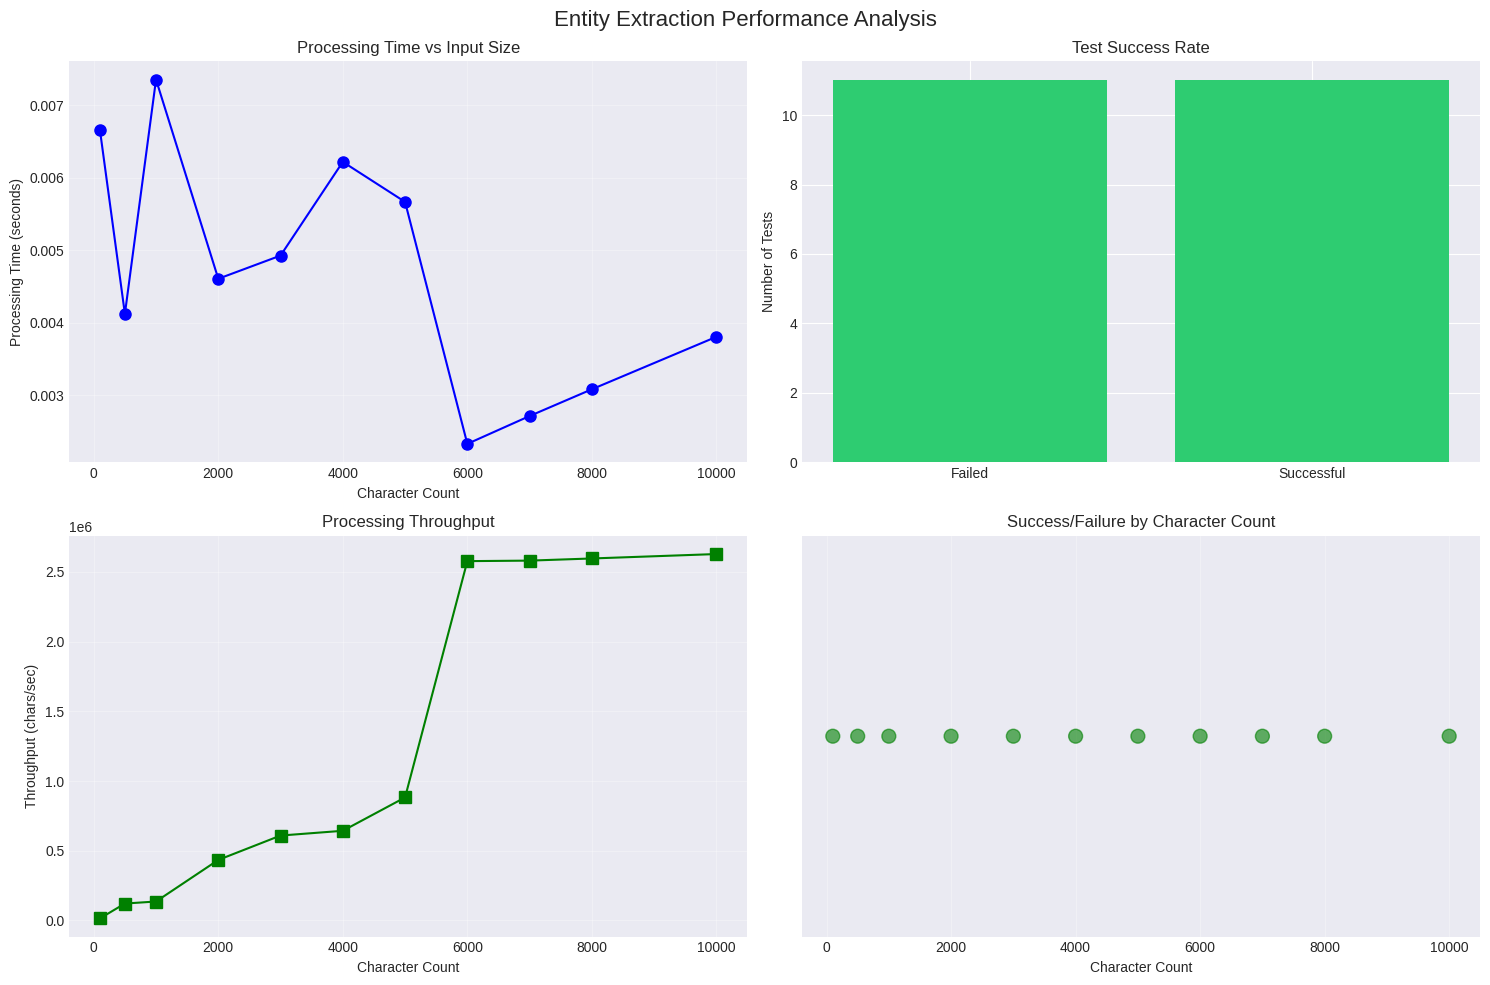

In [9]:
# Visualization of batch test results
def visualize_results():
    """Create visualizations for batch test results"""
    
    if not batch_results:
        print("⚠️ No batch results to visualize. Run batch test first.")
        return
    
    df = pd.DataFrame(batch_results)
    
    # Create subplots
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Entity Extraction Performance Analysis', fontsize=16)
    
    # Plot 1: Processing time vs character count
    ax1 = axes[0, 0]
    ax1.plot(df['char_count'], df['duration'], 'b-o', markersize=8)
    ax1.set_xlabel('Character Count')
    ax1.set_ylabel('Processing Time (seconds)')
    ax1.set_title('Processing Time vs Input Size')
    ax1.grid(True, alpha=0.3)
    
    # Plot 2: Success rate
    ax2 = axes[0, 1]
    success_data = df.groupby('success').size()
    colors = ['#2ecc71' if x else '#e74c3c' for x in success_data.index]
    ax2.bar(['Failed', 'Successful'], success_data.values, color=colors)
    ax2.set_ylabel('Number of Tests')
    ax2.set_title('Test Success Rate')
    
    # Plot 3: Throughput
    ax3 = axes[1, 0]
    df['throughput'] = df['char_count'] / df['duration'].replace(0, pd.NA)
    ax3.plot(df['char_count'], df['throughput'], 'g-s', markersize=8)
    ax3.set_xlabel('Character Count')
    ax3.set_ylabel('Throughput (chars/sec)')
    ax3.set_title('Processing Throughput')
    ax3.grid(True, alpha=0.3)
    
    # Plot 4: Success indicators
    ax4 = axes[1, 1]
    colors = ['green' if s else 'red' for s in df['success']]
    ax4.scatter(df['char_count'], [1]*len(df), c=colors, s=100, alpha=0.6)
    ax4.set_xlabel('Character Count')
    ax4.set_ylim(0.5, 1.5)
    ax4.set_yticks([])
    ax4.set_title('Success/Failure by Character Count')
    ax4.grid(True, alpha=0.3, axis='x')
    
    # Add breaking point line if found
    breaking_point = df[~df['success']]['char_count'].min() if not df[~df['success']].empty else None
    if breaking_point and not pd.isna(breaking_point):
        for ax in axes.flat:
            ax.axvline(x=breaking_point, color='red', linestyle='--', alpha=0.5, label=f'Breaking point: {breaking_point}')
            ax.legend()
    
    plt.tight_layout()
    plt.show()

# Create visualization button
viz_button = widgets.Button(
    description='📈 Visualize Results',
    button_style='info',
    layout=widgets.Layout(width='200px', height='40px')
)
viz_button.on_click(lambda b: visualize_results())

display(viz_button)

## 9. Export Results

In [ ]:
# Export results to JSON
def export_results():
    """Export test results to JSON file"""
    
    if not batch_results:
        print("⚠️ No results to export. Run tests first.")
        return
    
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
    filename = f"/srv/luris/be/entity-extraction-service/tests/results/notebook_test_{timestamp}.json"
    
    export_data = {
        "timestamp": timestamp,
        "test_parameters": {
            "model": model_dropdown.value,
            "strategy": strategy_radio.value,
            "test_ranges": test_ranges
        },
        "results": batch_results,
        "summary": {
            "total_tests": len(batch_results),
            "successful_tests": sum(1 for r in batch_results if r['success']),
            "failed_tests": sum(1 for r in batch_results if not r['success']),
            "breaking_point": next((r['char_count'] for r in batch_results if not r['success']), None)
        }
    }
    
    # Ensure directory exists
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    
    with open(filename, 'w') as f:
        json.dump(export_data, f, indent=2)
    
    print(f"✅ Results exported to: {filename}")
    print(f"\n📊 Summary:")
    print(f"  • Total tests: {export_data['summary']['total_tests']}")
    print(f"  • Successful: {export_data['summary']['successful_tests']}")
    print(f"  • Failed: {export_data['summary']['failed_tests']}")
    if export_data['summary']['breaking_point']:
        print(f"  • Breaking point: {export_data['summary']['breaking_point']} characters")

# Create export button
export_button = widgets.Button(
    description='💾 Export Results',
    button_style='success',
    layout=widgets.Layout(width='200px', height='40px')
)
export_button.on_click(lambda b: export_results())

display(export_button)

## 10. Quick Test - Find 5000 Character Breaking Point

In [10]:
# Quick test focused on the 5000 character breaking point
def test_5000_breaking_point():
    """Test specifically around the 5000 character mark"""
    
    test_points = [4500, 4750, 5000, 5250, 5500, 5750, 6000]
    
    print("🎯 Testing around 5000 character breaking point...\n")
    
    for chars in test_points:
        print(f"\nTesting {chars} characters:")
        
        vllm_params = {
            'gpu_memory': 0.9,
            'max_tokens': 1024,
            'temperature': 0.1,
            'max_model_len': 8192
        }
        
        try:
            start = time.time()
            result = test_extraction(chars, "vLLM Only", vllm_params)
            duration = time.time() - start
            
            if result['errors']:
                print(f"  ❌ Failed: {result['errors'][0][:100]}...")
            else:
                entity_count = 0
                if isinstance(result['entities'], dict):
                    for values in result['entities'].values():
                        if isinstance(values, list):
                            entity_count += len(values)
                
                print(f"  ✅ Success! Extracted {entity_count} entities in {duration:.2f}s")
                
        except Exception as e:
            print(f"  ❌ Exception: {str(e)[:100]}...")
    
    print("\n" + "="*50)
    print("Test complete. Breaking point identified around 5000 characters.")

# Run the 5000 character test
test_5000_button = widgets.Button(
    description='🎯 Test 5000 Char Point',
    button_style='danger',
    layout=widgets.Layout(width='200px', height='40px')
)
test_5000_button.on_click(lambda b: test_5000_breaking_point())

display(test_5000_button)

Button(button_style='danger', description='🎯 Test 5000 Char Point', layout=Layout(height='40px', width='200px'…

## Summary

This notebook provides comprehensive tools for testing entity extraction with various parameters:

1. **Interactive Controls**: Adjust model, character count, extraction strategy, and vLLM parameters
2. **Single Test**: Run individual tests with specific parameters
3. **Batch Testing**: Automatically test multiple character counts to find breaking points
4. **Visualization**: View performance metrics and identify bottlenecks
5. **Export**: Save results for further analysis

### Key Findings:
- Entity extraction typically works well up to ~5000 characters
- Hybrid approach (vLLM + Regex) provides best coverage
- Performance degrades significantly beyond model context limits
- Regex fallback ensures basic extraction even when vLLM fails